In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle
import re
import librosa as lb
from plotnine import *
from pandas.api.types import CategoricalDtype
import nbimporter
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import sys
import statistics
from time import perf_counter
from prettytable import PrettyTable

In [3]:
# Importing necessary functions
from online_dtw import flexdtw_alt, backtrace_flexdtw, find_best_endpoint, get_error, online_flex_dtw, L2norm, compute_cosdist_cost
from DTW import dtw_backtrace, dtw_numba

In [4]:
np.set_printoptions(threshold=sys.maxsize)

\begin{itemize}
    \item It seems like the paper runs the benchmarks and aggregates over ALL Mazurkas and not just different files
    \item testErrRates produces length of error rate arrays over 1 
    \item FastDTW function takes in a path A and path B, how can I make sure that I'm having an equivalent input for matrices of NxN for comparing runtime performance. To get over this, if the system we're computing is FastDTW, I am randomlay initializing two 12xN chroma feature vectors to be passed in as the paths so the resulting cost matrix is NxN
    \item refactor the way the dictionary values are set up from lists to just the np arrays themselves since we're only computing them once
\end{itemize}


## Error Benchmarking Functions

In [5]:
# Make a function that plots the error rate of FastDTW, DTW, and FlexDTW over different error tolerances


# Run DTW 10 times and store 10 errors in a dictionary, 
# Obtain error rates
# plot it against different tolerances

In [9]:
with open("data/pickle/errors_test.pickle", "rb") as f:
    test_errors = pickle.load(f)
# First plot the error rates at different values of L

In [7]:
def calcErrorRate(error, maxTol):
    """
    Calculate the error rates for each value
    within a NumPy array of errors
    
    Parameters:
        error (np.array): Array of error values between estimated and ground truth paths.
        maxTol (int): Maximum tolerance level (expressed in thousandths).
    
    Returns:
        np.array: Array of error rates for each tolerance level.
    """
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(error) > i/1000)
    return errRates

In [10]:
SYSTEMS = ['DTW', 'FlexDTW']

In [119]:
#TODO: Add Functionality to have runTests compute cost matrix given a path of annotations
def runPathTests(systems, C, steps, weights):
    """
    Runs different alignment algorithms and
    stores their returned paths in a dict
    
    Parameters:
        error (np.array): Array of error values between estimated and ground truth paths.
        maxTol (int): Maximum tolerance level (expressed in thousandths).
    
    Returns:
        np.array: Array of error rates for each tolerance level.
    """
    resultsDict = {system:[] for system in systems}
    for system in systems:
        if system == 'DTW':
            _, _, path = dtw_numba(C, steps, weights)
        elif system == 'OffFlex':
            _, path, _, _, _, _ = flexdtw_alt(C, steps, weights, buffer=5)
        elif system == "OnFlex":
            path = online_flex_dtw(C, steps, weights)

        resultsDict[system].append(path)
            
    return resultsDict

In [77]:
def runErrors(systems, pathDict, gt_path):
    # Iterate over the pathDict array
    numIterations = len(pathDict[systems[0]])
    errorsDict = {system:[] for system in systems}
    for system in systems:
        for path in pathDict[system]:
            currError = get_error(gt_path, path)
            errorsDict[system].append(currError)
    
    return errorsDict

In [78]:
def getErrorRates(errDict, maxTol=500):
    errRateDict = {system:[] for system in errDict.keys()}

    for system in errDict.keys():
        errors = errDict[system]
        for error in errors:
            errRate = calcErrorRate(error, maxTol)
            errRateDict[system].append(errRate)

    return errRateDict

In [112]:
def plotErrorRates(errRateDict, tolLevel):
    # Tol Level: in milliseconds
    # Go through key/value pair in errorRateDict
        # For each system, plot the error rate in a bar graph
    errRatePlot = {system:0 for system in errRateDict.keys()}
    for system, errRate in errRateDict.items():
        errRatePlot[system] = errRate[0][tolLevel]
        
    systems = errRatePlot.keys()
    errRates = errRatePlot.values()
    
    print(errRates)
    fig = plt.figure(figsize= (10, 5))
    
    plt.bar(systems, errRates, color='maroon', width=0.4)
    
    plt.xlabel("Systems")
    plt.ylabel("Error Rate (%)")
    plt.title("System Error Rates, Tol Lvl = 500ms")
    plt.show()

In [120]:
pathDict = runPathTests(systems, C, steps, weights)

dict_values([0.98989898989899, 0.9949494949494949, 0.9949494949494949])


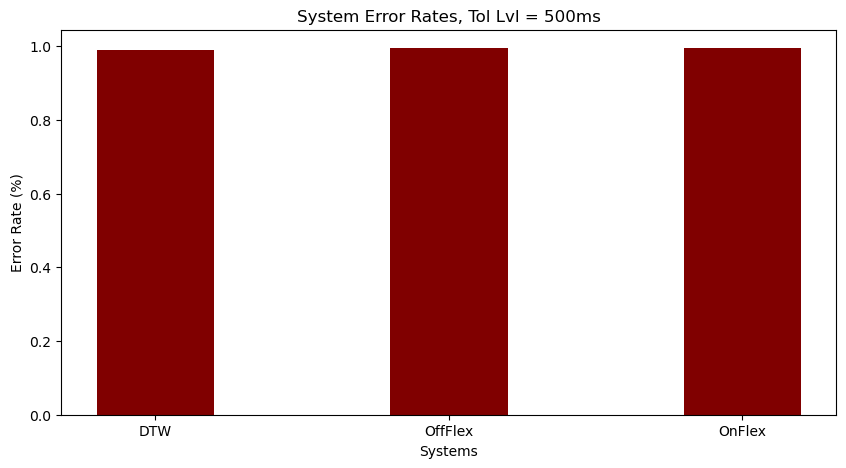

In [121]:
pathErrs_dict = runErrors(systems, pathDict, gt_path)
pathErrRates_dict = getErrorRates(pathErrs_dict)
plotErrorRates(pathErrRates_dict, 500)

In [122]:
systems

['DTW', 'OffFlex', 'OnFlex']

## Runtime Benchmark Functions

### Directions To Run Runtime Benchmark



In [14]:
def runRuntimeBenchmark(systems, steps, weights, N_list, numIterations=10):
    runtimesTestDict = runRuntimeTest(systems, steps, weights, N_list)
    dataTable = getRuntStats(runtimesTestDict, N_list)
    
    return dataTable

In [22]:
runRuntimeBenchmark(systems, steps, weights, N_list, 50)

+-----------+------+-----------------------+------------------------+
| Algorithm |  N   |     Mean - Runtime    |    StDev - Runtime     |
+-----------+------+-----------------------+------------------------+
|    DTW    | 100  | 0.0007027318701148033 | 0.0001653641086218518  |
|           | 200  | 0.0011114301159977913 | 0.00013578597626370646 |
|           | 500  |  0.005926109012216329 | 0.0008613195904018748  |
|           | 1000 |  0.02615156089887023  | 0.0004467771560366253  |
|  FastDTW  | 100  | 0.0014439895749092102 | 0.00011138657658495847 |
|           | 200  | 0.0013743401505053043 | 6.181667373866862e-05  |
|           | 500  | 0.0014655595645308495 | 4.314743148834422e-05  |
|           | 1000 | 0.0016234703361988068 | 7.981818134378468e-05  |
|  OffFlex  | 100  | 0.0004254004918038845 | 3.805910162026659e-05  |
|           | 200  | 0.0016090044751763343 | 2.6279039227041432e-05 |
|           | 500  |  0.007465322129428386 | 9.114929590880612e-05  |
|           | 1000 |

In [16]:
def runRuntimeTest(systems, steps, weights, N_list, numIterations=10):
    runtimesDict = {system:[] for system in systems}
    
    # For each setting of N
    for N in N_list:
        # Initializing random matrices
        randMat = np.random.random((N, N))
        for system in systems:
            times = []

            if system == "FastDTW":
                randChroma_a = np.random.random((12, N))
                randChroma_b = np.random.random((12, N))
            for i in range(numIterations):
                #TODO: Incorporate Match algorithm
                if system == "DTW":
                    start_time = perf_counter()
                    _, _, path = dtw_numba(randMat, steps, weights)
                    end_time = perf_counter()
                    times.append(end_time - start_time)
                elif system == "FastDTW":
                    start_time = perf_counter()
                    distance, path = fastdtw(randChroma_a, randChroma_b, dist=euclidean)
                    end_time = perf_counter()
                    times.append(end_time - start_time)
                elif system == "OffFlex":
                    start_time = perf_counter()
                    _, path, _, _, _, _ = flexdtw_alt(randMat, steps, weights, buffer=5)
                    end_time = perf_counter()
                    times.append(end_time - start_time)
                    
                elif system == "OnFlex":
                    start_time = perf_counter()
                    path = online_flex_dtw(randMat, steps, weights)
                    end_time = perf_counter()
                    times.append(end_time - start_time)
            if len(times) == 10:
                runtimesDict[system].append(times)       
    return runtimesDict

In [17]:
def getRuntStats(runtimesDict, N_list):
    # Get mean and StDev of each entry in 
    runtimeStats = {system:[] for system in systems}
    
    # Building Stats Dictionary
    for system, runtimes in runtimesDict.items():
        for i in range(len(runtimes)):
            currRuntime = np.array(runtimes[i])
            stats = (np.mean(currRuntime), np.std(currRuntime))
            runtimeStats[system].append(stats)
        
    # Visualizing Runtime
    statsTable = PrettyTable()
    statsTable.field_names = ["Algorithm", "N", "Mean - Runtime", "StDev - Runtime"]
    
    for system, stats in runtimeStats.items():
        for i in range(len(N_list)):
            if i == 0:
                statsTable.add_row([system, N_list[i] , stats[i][0], stats[i][1]])
            else:
                 statsTable.add_row(["", N_list[i] ,stats[i][0], stats[i][1]])
                

    print(statsTable)

In [117]:
N_list = [100, 200, 500, 1000]
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
systems = ["DTW", "OffFlex", "OnFlex"]

In [19]:
runtimesTestDict = runRuntimeTest(systems, steps, weights, N_list)

In [20]:
getRuntStats(runtimesTestDict, N_list)

+-----------+------+-----------------------+------------------------+
| Algorithm |  N   |     Mean - Runtime    |    StDev - Runtime     |
+-----------+------+-----------------------+------------------------+
|    DTW    | 100  |  0.13386318180710077  |   0.4009505833398605   |
|           | 200  | 0.0008819248527288437 | 8.441812697008968e-05  |
|           | 500  |  0.00526898168027401  | 0.0004929952393231354  |
|           | 1000 |  0.024710047617554666 | 0.0022919322567629867  |
|  FastDTW  | 100  | 0.0011874736286699773 | 7.679783819217614e-05  |
|           | 200  |  0.001295368280261755 | 6.308186084602021e-05  |
|           | 500  | 0.0013967374339699744 | 3.7040839278947316e-05 |
|           | 1000 | 0.0017216984182596208 | 0.00010115133222550861 |
|  OffFlex  | 100  |   0.1283138138242066  |   0.3840350563222992   |
|           | 200  |  0.001206604577600956 | 3.285927124287784e-05  |
|           | 500  |  0.007427886221557855 | 8.518800066568514e-05  |
|           | 1000 |

## Helper Functions

In [27]:
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
C = np.load("data/NPYs/costMat.npy")
gt1, gt2 = np.load("data/NPYs/gt1.npy"), np.load("data/NPYs/gt2.npy")
gt_path = np.array([gt1, gt2])

In [66]:
path = online_flex_dtw(C, steps, weights, 0.7)

In [59]:
errTest = get_error(gt_path, path)

In [69]:
errTest

array([ 11.709138 ,  11.0591275,  10.6873925,  10.4200455,  10.2408165,
        10.0275055,   9.778345 ,   9.3827435,   8.8810655,   9.432109 ,
        10.538504 ,  11.32449  ,  11.767347 ,  12.374489 ,  12.652018 ,
        13.028934 ,  13.665487 ,  14.414876 ,  14.960023 ,  15.344989 ,
        15.882153 ,  16.261044 ,  16.592789 ,  17.072199 ,  17.554989 ,
        17.867801 ,  18.384989 ,  18.866303 ,  19.076871 ,  19.386395 ,
        19.34     ,  19.141745 ,  19.737573 ,  19.855964 ,  19.742495 ,
        20.355284 ,  19.689796 ,  19.4012245,  18.843855 ,  19.147301 ,
        19.25     ,  19.213016 ,  18.923719 ,  18.103991 ,  17.405419 ,
        17.636826 ,  17.439319 ,  17.2775055,  16.5456695,  15.8024945,
        15.2107025,  14.441678 ,  14.12     ,  14.58662  ,  14.95365  ,
        15.21     ,  15.196372 ,  15.492245 ,  15.464989 ,  15.474989 ,
        15.208662 ,  14.82     ,  14.845963 ,  14.399774 ,  14.606779 ,
        14.653264 ,  14.756599 ,  15.09     ,  14.511927 ,  14.1

In [86]:
errRates = calcErrorRate(errTest, 500)

In [87]:
errRates

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [90]:
errRates[480] = 1000000

In [92]:
errRates.shape

(501,)

In [94]:
errRates[500]

0.9949494949494949